# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #4
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (Continued)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x - 0.0005\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Part A: Further problems with descent algorithms
Using your implementation of gradient descent and stochastic gradient descent, document the behaviour of your two algorithms for the following starting points, and for a number of stepsizes of your choice:
- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$
Based on your analysis of the lost function $L$, explain what is happening to your descent algorithms.

### Part B: Simulated Annealing
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

**Extra Credit**
For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [1]:
%matplotlib inline
import theano
from theano import *
import theano.tensor as T
import pandas as pd
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from numpy import linalg 

## Visualize the Loss Function

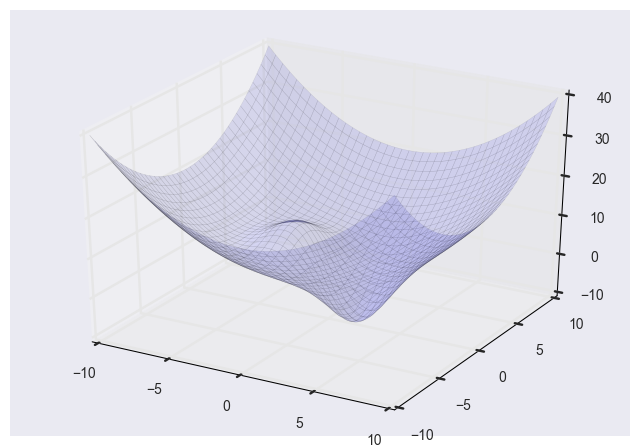

In [2]:
from mpl_toolkits.mplot3d import Axes3D
data = pd.read_csv('HW3_data.csv',header=None)
#print (data.shape)
data.T.shape
df = pd.DataFrame(data)
data_x = df.T[0]
data_y = df.T[1]
x = T.vector('x')
y = T.vector('y')
l1 = T.dscalar('l1')
l2 = T.dscalar('l2')

cost = 0.000045*l2**2*y - 0.000098*l1**2*x + 0.003926*l1*x*np.exp((y**2-x**2)*(l1**2+l2**2))
#print (np.sum(cost))
f = function([x,y,l1,l2],cost)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
la1 = np.arange(-10,10,0.05)
la2 = np.arange(-10,10,0.05)
X, Y = np.meshgrid(la1, la2)
#X, Y = np.meshgrid(data_x, data_y)
#print ()
zs = np.array([np.sum(f(data_x,data_y,x,y)) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
ax.plot_surface(X,Y, Z,alpha = 0.1)


plt.show()




## Part A

### Gradient Decent 

In [3]:
def Gradient_Decent(ini_l1,ini_l2,threshold,data_x,data_y,eta):
    start_time = time.time()
    #lam1 = theano.shared(2+np.random.randn(),name='lam1',borrow=True)
    #lam2 = theano.shared(np.random.randn(),name='lam2',borrow=True)
    lam1 = theano.shared(ini_l1,name='lam1',borrow=True)
    lam2 = theano.shared(ini_l2,name='lam2',borrow=True)
    #print(lam1)
    print("Initial model:")
    print('Lambda1:',lam1.get_value())
    print('Lambda2:',lam2.get_value())

    #cost = T.sum(0.000045*lam2**2*data_y - 0.000098*lam1**2*data_x + 0.003926*lam1*data_x*T.exp((data_y**2-data_x**2)*(lam1**2+lam2**2)))


    cost = 1000 * T.mean(0.000045*lam2**2*y - 0.000098*lam1**2*x +0.003926*lam1*x* T.exp((-0.1)*(lam1**2 + lam2**2)))

    glam1 = T.grad(cost=cost, wrt=lam1)
    glam2 = T.grad(cost=cost, wrt=lam2)                   # Compute the gradient of the cost

    # Compile. What is a good learning rate?
    #eta = 0.001 # Learning rate
    train = theano.function(
              inputs=[x,y],
              outputs = [cost,lam1,lam2,glam1],
              updates=((lam1, lam1 - eta * glam1), (lam2, lam2 - eta * glam2)),name='train')

    n_epochs = 50000
    ite = 0
    maxsteps = 40000
    lamllist = list()
    lam2list = list()
    #print (glam1)
    for i in range(n_epochs):
        cost1, lam1, lam2,glam1 = train(data_x, data_y)
        cost2, lam1, lam2,glam2 = train(data_x, data_y)
        lamllist.append(lam1)
        lam2list.append(lam2)
        ite = ite + 1
        d = abs(cost1 - cost2)
        if (d < threshold):
            print ('Iterations:',ite)
            print ('lambda1 is:',lam1)
            print ('Lambda2 is:',lam2)
            break

               
        if maxsteps:
            if (ite == maxsteps):
                print("maxsteps:",maxsteps)
                break

    return lamllist,lam2list
    print("run time: %s seconds " % (time.time() - start_time))
    print ('Average time for gd: %s seconds'% ((time.time() - start_time)/ite))

### Stochastic Gradient Decent 

In [4]:
def stochastic_gradient(ini_l1,ini_l2,threshold,data_x,data_y,eta):
    import time
    start_time = time.time()
    #lam1 = theano.shared(2+np.random.randn(),name='lam1',borrow=True)
    #lam2 = theano.shared(np.random.randn(),name='lam2',borrow=True)
    lam1 = theano.shared(ini_l1,name='lam1',borrow=True)
    lam2 = theano.shared(ini_l2,name='lam2',borrow=True)
    #print(lam1)
    print("Initial model:")
    print(lam1.get_value())
    print(lam2.get_value())

    x1 = T.dscalar('x1')
    y1 = T.dscalar('y1')
    
    cost = 1000 * (0.000045*lam2**2*y1 - 0.000098*lam1**2*x1 +0.003926*lam1*x1* T.exp((-0.1)*(lam1**2 + lam2**2)))
    


    glam1 = T.grad(cost=cost, wrt=lam1)
    glam2 = T.grad(cost=cost, wrt=lam2)                   # Compute the gradient of the cost

    # Compile. What is a good learning rate?
    #eta = 0.001 # Learning rate

    train1 = theano.function(
              inputs=[x1,y1],
              outputs = [cost,lam1,lam2],
              updates=((lam1, lam1 - eta * glam1), (lam2, lam2 - eta * glam2)),name='train')


    n_epochs = 500000
    ite = 0
    s = 0
  #  print (data_x[s])
    costlist1 = list()
    costlist2 = list()
    counter = 0
    c = 0
    history1 = list()
    history2 = list()
    maxsteps = 20000
    for i in range(n_epochs):
        counter  = counter + 1
        cost1, lam1, lam2 = train1(data_x[s], data_y[s])
        cost2, lam1, lam2 = train1(data_x[s], data_y[s])
        
        costlist1.append(cost1)
        costlist2.append(cost2)
        costsum1 = np.mean(costlist1)*10000
        costsum2 = np.mean(costlist2)*10000
        history1.append(lam1)
        history2.append(lam2)
        #print (lam1)
        #print (costsum2)
        s = s + 1
        #print ('ll,l2',lam1,lam2)
        if (s == len(data_x)):
            neworder = np.random.permutation(len(data_x))
            data_x = data_x[neworder]
            data_y = data_y[neworder] 
            s = 0

        ite = ite + 1
        d = abs(costsum1 - costsum2)
        #print (d)
        if (d < threshold):

            print ('Iterations:',ite)
            print ('lambda1 is:',lam1)
            print ('Lambda2 is:',lam2)
            break
        if maxsteps:
            if (ite == maxsteps):
                print("maxsteps:",maxsteps)
                break
    
    print("run time: %s seconds " % (time.time() - start_time))
    print ('Average time for sgd: %s seconds'%((time.time() - start_time)/ite))


  

#### GD: Step length = 0.1 

In [5]:
## GD: Step length = 0.01 
threshold = 1e-5
lam = [[-2.47865,0.],[-3.,0.],[-5.,0.],[-10.,0.]]
eta = 0.01
lam1list = list()
lam2list = list()
print ('Using Gradient Decent:\n')
for i in range(len(lam)):
    lam1 = lam[i][0]
    lam2 = lam[i][1]
    lam1,lam2 = Gradient_Decent(lam1,lam2,threshold,data_x,data_y,eta)
    lam1list.append(lam1)
    lam2list.append(lam2)
    print ('\n')

Using Gradient Decent:

Initial model:
Lambda1: -2.47865
Lambda2: 0.0
Iterations: 1
lambda1 is: -2.4786500079666642
Lambda2 is: 0.0


Initial model:
Lambda1: -3.0
Lambda2: 0.0
Iterations: 1169
lambda1 is: -5.072614653091973
Lambda2 is: 0.0


Initial model:
Lambda1: -5.0
Lambda2: 0.0
Iterations: 103
lambda1 is: -5.072460958078614
Lambda2 is: 0.0


Initial model:
Lambda1: -10.0
Lambda2: 0.0
Iterations: 1612
lambda1 is: -5.6606168972867446
Lambda2 is: 0.0




In [29]:
#### GD: Step length = 0.01 

In [7]:
threshold = 1e-5
lam = [[-2.47865,0.],[-3.,0.],[-5.,0.],[-10.,0.]]
eta = 0.01
lam1list = list()
lam2list = list()
print ('Using Gradient Decent:\n')
for i in range(len(lam)):
    lam1 = lam[i][0]
    lam2 = lam[i][1]
    lam1,lam2 = Gradient_Decent(lam1,lam2,threshold,data_x,data_y,eta)
    lam1list.append(lam1)
    lam2list.append(lam2)
    print ('\n')

Using Gradient Decent:

Initial model:
Lambda1: -2.47865
Lambda2: 0.0
Iterations: 1
lambda1 is: -2.4786500079666642
Lambda2 is: 0.0


Initial model:
Lambda1: -3.0
Lambda2: 0.0
Iterations: 1169
lambda1 is: -5.072614653091973
Lambda2 is: 0.0


Initial model:
Lambda1: -5.0
Lambda2: 0.0
Iterations: 103
lambda1 is: -5.072460958078614
Lambda2 is: 0.0


Initial model:
Lambda1: -10.0
Lambda2: 0.0
Iterations: 1612
lambda1 is: -5.6606168972867446
Lambda2 is: 0.0




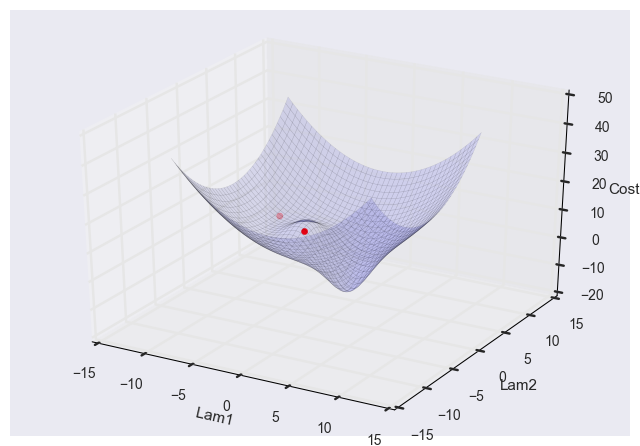

In [8]:
len(lam1list)
from mpl_toolkits.mplot3d import Axes3D
data = pd.read_csv('HW3_data.csv',header=None)
#print (data.shape)
data.T.shape
df = pd.DataFrame(data)
data_x = df.T[0]
data_y = df.T[1]
x = T.vector('x')
y = T.vector('y')
l1 = T.dscalar('l1')
l2 = T.dscalar('l2')

cost = 0.000045*l2**2*y - 0.000098*l1**2*x + 0.003926*l1*x*np.exp((y**2-x**2)*(l1**2+l2**2))
#print (np.sum(cost))
f = function([x,y,l1,l2],cost)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
la1 = np.arange(-10,10,0.05)
la2 = np.arange(-10,10,0.05)
X, Y = np.meshgrid(la1, la2)
#X, Y = np.meshgrid(data_x, data_y)
#print ()
zs = np.array([np.sum(f(data_x,data_y,x,y)) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)
ax.plot_surface(X,Y, Z,alpha = 0.1)


#for i in range (len(Lambda1))


xcod = [lam1list[0][-1],lam1list[2][-1]]
ycod = [lam2list[0][-1],lam2list[2][-1]]
zcod = [np.sum(f(data_x,data_y,lam1list[2][-1],lam2list[2][-1])),np.sum(f(data_x,data_y,lam1list[0][-1],lam2list[0][-1]))]

sc = ax.scatter(xcod,ycod,zcod,color ='r')
#ax.plot_surface(X, Y, Z,alpha = 0.1)

ax.set_xlabel('Lam1 ')
ax.set_ylabel('Lam2')
ax.set_zlabel('Cost')
plt.show()





  $\text{ Using GD with inappropriate initial values, the point goes to the local minimum as shown in this plot.} $

## Results from SGD

### eta = 0.01

In [9]:
threshold = 1e-5
lam = [[-2.47865,0.],[-3.,0.],[-5.,0.],[-10.,0.]]
eta = 0.01
print ('Using Stochastic Gradient Decent:\n')
for i in range(len(lam)):
    lam1 = lam[i][0]
    lam2 = lam[i][1]
    stochastic_gradient(lam1,lam2,threshold,data_x,data_y,eta)
    print ('\n')

Using Stochastic Gradient Decent:

Initial model:
-2.47865
0.0
Iterations: 1
lambda1 is: -2.478648922931284
Lambda2 is: 0.0
run time: 0.2620530128479004 seconds 
Average time for sgd: 0.26206302642822266 seconds


Initial model:
-3.0
0.0
maxsteps: 20000
run time: 89.91655802726746 seconds 
Average time for sgd: 0.004495828950405121 seconds


Initial model:
-5.0
0.0
maxsteps: 20000
run time: 92.70008516311646 seconds 
Average time for sgd: 0.004635005056858063 seconds


Initial model:
-10.0
0.0
maxsteps: 20000
run time: 82.85516715049744 seconds 
Average time for sgd: 0.004142759108543396 seconds




### eta = 0.1

In [10]:
threshold = 1e-5
lam = [[-2.47865,0.],[-3.,0.],[-5.,0.],[-10.,0.]]
eta = 0.1
print ('Using Stochastic Gradient Decent:\n')
for i in range(len(lam)):
    lam1 = lam[i][0]
    lam2 = lam[i][1]
    stochastic_gradient(lam1,lam2,threshold,data_x,data_y,eta)
    print ('\n')

Using Stochastic Gradient Decent:

Initial model:
-2.47865
0.0
Iterations: 1
lambda1 is: -2.4786392293128405
Lambda2 is: 0.0
run time: 0.19142508506774902 seconds 
Average time for sgd: 0.19143295288085938 seconds


Initial model:
-3.0
0.0
maxsteps: 20000
run time: 73.64010691642761 seconds 
Average time for sgd: 0.003682006096839905 seconds


Initial model:
-5.0
0.0
maxsteps: 20000
run time: 79.30848789215088 seconds 
Average time for sgd: 0.003965425145626068 seconds


Initial model:
-10.0
0.0
maxsteps: 20000
run time: 85.31428980827332 seconds 
Average time for sgd: 0.004265715301036835 seconds




## Summary:


When the initial points become far away from the global minimal, gradient descent methods took a longer period of time bacause finding the gradient at a particular point of a high-dimensional response surface may require a considerable amount of experiments especially when the distance between optimal point and starting point is far. More importantly, GD could not make sure to find the global minimal, instead, it may find a local minimun and be trapped in this minimun under complicated distribution as shown in the plot above

For stochastic gradient decent method, when the starting point is not near global minimal, within 20000 steps, it could not find the optimal point. In addition, SGD is sensitive to feature scaling such as step length settings. Therefore, without a good pre-setting for SGD, this method may not work very well as shown from the results in the problem.


### Part B: Simulated Annealing
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our lost function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

**Extra Credit**
For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

In [12]:
import math
# define proposal function
from functools import partial
energyfunc = lambda l: 1000 * np.mean(0.000045*l[0][1]**2*data_y - 0.000098*l[0][0]**2*data_x + 0.003926*l[0][0]* data_x *np.exp((-0.1)*(l[0][0]**2+l[0][1]**2)))
cov = [[1, 0], [0, 1]]
#x, y = np.random.multivariate_normal(mean, cov, 5000)
x = [[-5, 0]]
pf = lambda x: np.random.multivariate_normal(x[0], cov, 1) # proposal


tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function


In [23]:
def sa1(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc,threshold):
    import time
    start_time = time.time()
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    print (best_energy)
    accepted=0
    total=0
    d =1
    new_solution_list = list()
    for index in range(epochs):
        if (d < threshold):
            break
        print("Epoch", index)
        if (index > 0):
            T = tempfunc(T)  # reduce the temperature
            length=iterfunc(length) # increase the length
        print("Temperature", T, "Length", length)
        
        for it in range(length):
            total+=1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                if (new_energy < best_energy):
                    d = abs(new_energy - best_energy)
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                     
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy,total))
            if (d< threshold):
                break
        
    
    best_meta=dict(index=best_index, temp=best_temp)
    print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    print("run time: %s seconds " % (time.time() - start_time))
    #print ('Average time for annealing: %s seconds'%((time.time() - start_time)/ite))

    return best_meta, best_solution, best_energy, accumulator

In [24]:
threshold = 1e-10
lam = [[-5,0]]
inits=dict(solution=lam, length=500, T=10)
print (inits)
bmeta, bs, be, out1 = sa1(energyfunc, inits, 30, tf, itf, pf,threshold)

{'length': 500, 'T': 10, 'solution': [[-5, 0]]}
0.5172561462035863
Epoch 0
Temperature 10 Length 500
Epoch 1
Temperature 8.0 Length 600
Epoch 2
Temperature 6.4 Length 720
Epoch 3
Temperature 5.120000000000001 Length 864
Epoch 4
Temperature 4.096000000000001 Length 1037
Epoch 5
Temperature 3.276800000000001 Length 1245
Epoch 6
Temperature 2.621440000000001 Length 1494
Epoch 7
Temperature 2.097152000000001 Length 1793
Epoch 8
Temperature 1.6777216000000008 Length 2152
Epoch 9
Temperature 1.3421772800000007 Length 2583
Epoch 10
Temperature 1.0737418240000005 Length 3100
Epoch 11
Temperature 0.8589934592000005 Length 3720
Epoch 12
Temperature 0.6871947673600004 Length 4464
Epoch 13
Temperature 0.5497558138880003 Length 5357
Epoch 14
Temperature 0.4398046511104003 Length 6429
Epoch 15
Temperature 0.3518437208883203 Length 7715
Epoch 16
Temperature 0.28147497671065624 Length 9258
Epoch 17
Temperature 0.22517998136852502 Length 11110
Epoch 18
Temperature 0.18014398509482002 Length 13332
Epoch

In [25]:
print ('best solution:')
print(bs[0])

best solution:
[ 2.05383602  0.        ]


### When I set a different covariance matrix for the proposal:

In [26]:
cov = [[10, 0], [10, 0]]
#x, y = np.random.multivariate_normal(mean, cov, 5000)
x = [[-5, 0]]
pf = lambda x: np.random.multivariate_normal(x[0], cov, 1) # proposal


tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function
threshold = 1e-10
lam = [[-5,0]]
inits=dict(solution=lam, length=500, T=10)
print (inits)
bmeta, bs, be, out = sa1(energyfunc, inits, 30, tf, itf, pf,threshold)

{'length': 500, 'T': 10, 'solution': [[-5, 0]]}
0.5172561462035863
Epoch 0
Temperature 10 Length 500
Epoch 1
Temperature 8.0 Length 600
Epoch 2
Temperature 6.4 Length 720
Epoch 3
Temperature 5.120000000000001 Length 864
Epoch 4
Temperature 4.096000000000001 Length 1037
Epoch 5
Temperature 3.276800000000001 Length 1245
Epoch 6
Temperature 2.621440000000001 Length 1494
Epoch 7
Temperature 2.097152000000001 Length 1793
Epoch 8
Temperature 1.6777216000000008 Length 2152
Epoch 9
Temperature 1.3421772800000007 Length 2583
Epoch 10
Temperature 1.0737418240000005 Length 3100
Epoch 11
Temperature 0.8589934592000005 Length 3720
Epoch 12
Temperature 0.6871947673600004 Length 4464
Epoch 13
Temperature 0.5497558138880003 Length 5357
Epoch 14
Temperature 0.4398046511104003 Length 6429
Epoch 15
Temperature 0.3518437208883203 Length 7715
Epoch 16
Temperature 0.28147497671065624 Length 9258
Epoch 17
Temperature 0.22517998136852502 Length 11110
Epoch 18
Temperature 0.18014398509482002 Length 13332
Epoch

In [27]:
print ('best solution:')
print(bs[0])

best solution:
[ 2.0536779  0.       ]


### Summary
#### Compared with the performance of GD and SGD, simulated annealing performs better in finding a global minumal in a large search space. 

Since as T is decreasing to 0, we get a peakier and peakier distribution around the global minimum. When T→0, we get towards a delta function at the optimum and get a global minimum instead of a distribution.


**Extra Credit**
For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

81033
591884


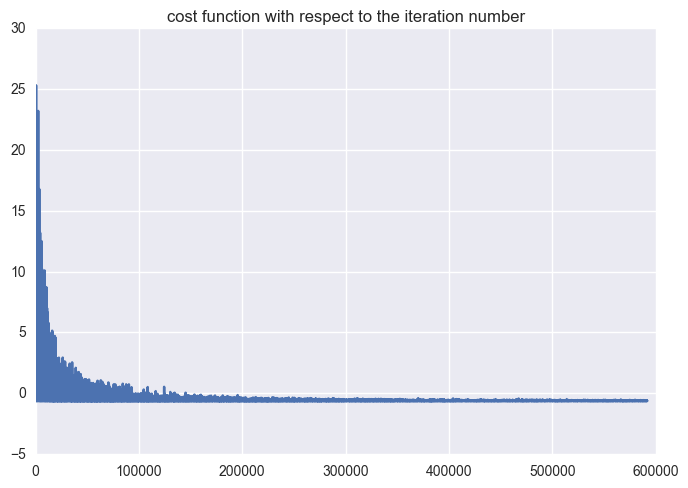

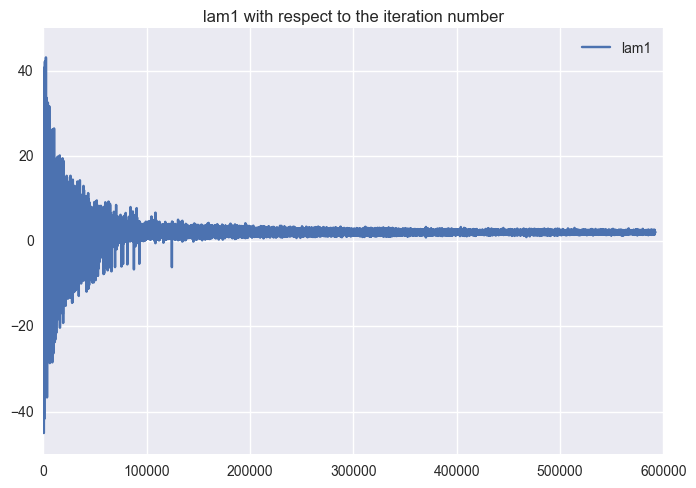

<function matplotlib.pyplot.show>

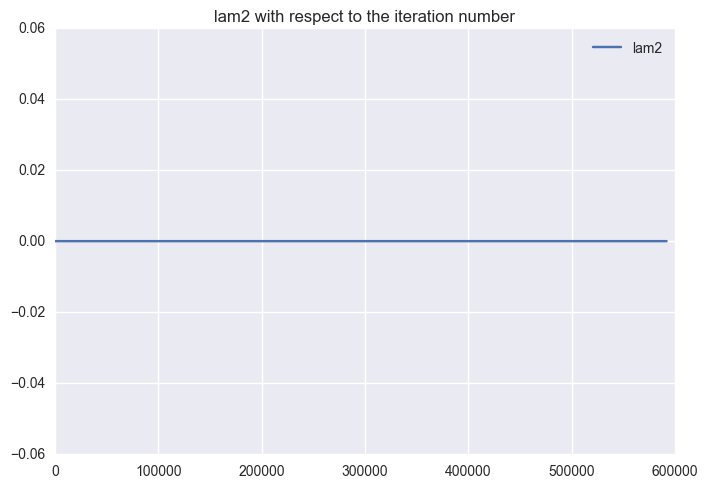

In [28]:

#print (out[1][1])
result1 = list()
result2 = list()
costlist = list()
for i in range(len(out1)):
    result1.append(out1[i][1][0][0])
    result2.append(out1[i][1][0][1])


#print (result[0])
for i in range(len(out1)):
    costlist.append(out1[i][2])
#print (costlist)
ite = np.linspace(0.,len(out1),len(out1))
print (len(ite))
plt.plot(ite,costlist)
plt.title('cost function with respect to the iteration number')
plt.show()
plt.plot(ite,result1,label = 'lam1')
plt.title('lam1 with respect to the iteration number')
plt.legend()
plt.show()
plt.plot(ite,result2,label = 'lam2')
plt.title('lam2 with respect to the iteration number')


plt.legend()
plt.show

#print (eout[1])
#

## Summary

$\lambda 1$ and $\lambda 2$  and cost generated by simulated anealing is a stationary Markov chain. As validated in the plots above, cost and lambda both converge to a stable point. AS the lecture notes say, an irreducible (goes everywhere) and aperiodic (no cycles) markov chain will converge to a stationary markov chains. Here, simulated annealing algorithms are based on independent Metropolis-Hastings moves interacting sequentially with a selection-resampling type mechanism.